In [245]:
from keras.models import Model
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras import regularizers
from keras.engine.topology import Input
from keras.optimizers import Adam
from keras import backend as K
#import numpy as np

In [246]:
from Prepare_data import Get_data, Shuffle_data
from utils import to_file_params, TimeControll

In [247]:
from keras.callbacks import ModelCheckpoint

In [248]:
import matplotlib.pyplot as plt

In [249]:
import json

In [250]:
from os.path import exists
from os import makedirs

In [307]:
TYPE = 0
DESCRIPTION = "Turning num epochs"
RESOLUTION = (96,96)
GRAYSCALE = True
INPUT_SHAPE = (RESOLUTION[0], RESOLUTION[1], 1 if GRAYSCALE else 3)
NUM_EXAMPLES = 15 if TYPE != 0 else 2
NUM_FOLDERS = 150 if TYPE != 0 else 2
START_FOLDER = 500 if TYPE != 0 else 0
BATCH_SIZE = 400 if TYPE != 0 else 1
EPOCHS = 50 if TYPE != 0 else 20

LEARNING_RATE = 0.001
L2 = 0.0007

VALIDATION_SIZE = 0.2
RANDOM_STATE = 2018

NAME_HISTORY = f"history/FaceModel_whaleType/train/history{TYPE}.txt" if TYPE != 0 else f"history/FaceModel_whaleType/train/history_train_test{TYPE}.txt"
NAME_JSON_HISTORY = f"history/FaceModel_whaleType/JSON/history{TYPE}.json" if TYPE != 0 else f"history/FaceModel_whaleType/JSON/history_test{TYPE}.json"

NAME_FIGURE = f"figures/FaceModel_whaleType/train/{TYPE}/"

SAVE_MODEL_DIR = "models/FaceModel_whaleType"
SAVE_EACH_MODEL_DIR = f"{SAVE_MODEL_DIR}/{TYPE}"

SAVE_MODEL_NAME = f"{SAVE_MODEL_DIR}/Model_{TYPE}.h5" if TYPE != 0 else f"{SAVE_MODEL_DIR}/Model_test_{TYPE}.h5" 
SAVE_EACH_MODEL_NAME = (f"{SAVE_EACH_MODEL_DIR}/Model_" + "{epoch:02d}-{val_loss:.2f}.h5") if TYPE != 0 else (f"{SAVE_EACH_MODEL_DIR}/Model_test_" + "{epoch:02d}-{val_loss:.2f}.h5")

DATASET_P = DATASET_N = "../Datasets/Faces_dataset/Faces"

In [252]:
X1_input, X2_input, Y_input = Get_data(path_p = DATASET_P, 
                                       path_n = DATASET_N,
                                      resolution = RESOLUTION,
                                      grayscale = GRAYSCALE,
                                      num_examples = NUM_EXAMPLES,
                                      num_folders = NUM_FOLDERS,
                                      input_shape = INPUT_SHAPE,
                                      start_folder = START_FOLDER)

(2, 2, 96, 96, 1)
(2, 2, 96, 96, 1)
new_shape = 4, 96, 96, 1
new_shape = 4, 96, 96, 1
(4, 1)
(2, 2, 96, 96, 1)
(2, 2, 96, 96, 1)
new_shape = 4, 96, 96, 1
new_shape = 4, 96, 96, 1
Y_input_n.shape:  (4, 1)
X1_input.shape:  (8, 96, 96, 1)
X2_input.shape:  (8, 96, 96, 1)
Y_input.shape:  (8, 1)


In [253]:
X_train, X_val, Y_train, Y_val = Shuffle_data(X1_input, X2_input, Y_input, VALIDATION_SIZE, RANDOM_STATE)


X_train.shape:  (6, 96, 96, 1)
X_val.shape:  (2, 96, 96, 1)
Y_train.shape:  (6, 1)
Y_val.shape:  (2, 1)


In [254]:
def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

In [255]:
def build_model(img_shape, lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(1):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(2): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(2): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(2): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(2): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
    ############
    # HEAD MODEL
    ############
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])

    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    # Weighted sum implemented as a Dense layer.
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

In [256]:
FaceModel, _,_ = build_model(INPUT_SHAPE, lr = LEARNING_RATE, l2 = L2)


In [284]:
history = AccuracyHistory()

In [285]:
to_file_params(NAME_HISTORY, [f"input_shape = {INPUT_SHAPE}\nnum_examples = {NUM_EXAMPLES}\nnum_folders = {NUM_FOLDERS}\nstart_folder = {START_FOLDER}\nbatch_size = {BATCH_SIZE}\nepochs = {EPOCHS}\nlearning_rate = {LEARNING_RATE}\nl2 = {L2}\nvalidation_size = {VALIDATION_SIZE}\nrandom_state = {RANDOM_STATE}\nname_history = {NAME_HISTORY}\nsave_model_name = {SAVE_MODEL_NAME}\ndataset_positive = {DATASET_P}\ndataset_negative = {DATASET_N}\ndescription = {DESCRIPTION}\n"], with_lines = False)

to_file_params(NAME_HISTORY, [f"all_examples = {Y_input.shape[0]}\ntrain_examples = {Y_train.shape[0]}\ntest_examples = {Y_val.shape[0]}\n"], with_lines = False)

In [270]:
if not exists(SAVE_EACH_MODEL_DIR):
    makedirs(SAVE_EACH_MODEL_DIR)

In [271]:
callbacks = ModelCheckpoint(SAVE_EACH_MODEL_NAME, 
                            monitor=["val_loss"], 
                            mode="min",
                            verbose = 1)

In [261]:
callback_list = [callbacks]

In [286]:
my_time = TimeControll()
time_start = my_time.get_start_time()
to_file_params(NAME_HISTORY, [f"\tStart time = {time_start[0]}:{time_start[1]}"], with_lines = False)

In [264]:
hist = FaceModel.fit(X_train,Y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   verbose = 1,
                   validation_data = (X_val, Y_val),
                   callbacks = callback_list)

Train on 6 samples, validate on 2 samples
Epoch 1/20
6/6 [==============================] - 105s 17s/step - loss: 3.2854 - binary_crossentropy: 0.6939 - acc: 0.3333 - val_loss: 10.3888 - val_binary_crossentropy: 8.0590 - val_acc: 0.5000

Epoch 00001: saving model to models/FaceModel_whaleType/0/Model_test_01-10.39.h5
Epoch 2/20
6/6 [==============================] - 2s 411ms/step - loss: 2.8447 - binary_crossentropy: 0.6932 - acc: 0.5000 - val_loss: 9.9720 - val_binary_crossentropy: 8.0590 - val_acc: 0.5000

Epoch 00002: saving model to models/FaceModel_whaleType/0/Model_test_02-9.97.h5
Epoch 3/20
6/6 [==============================] - 3s 567ms/step - loss: 2.4536 - binary_crossentropy: 0.6937 - acc: 0.5000 - val_loss: 9.6167 - val_binary_crossentropy: 8.0590 - val_acc: 0.5000

Epoch 00003: saving model to models/FaceModel_whaleType/0/Model_test_03-9.62.h5
Epoch 4/20
6/6 [==============================] - 2s 272ms/step - loss: 2.1238 - binary_crossentropy: 0.6935 - acc: 0.5000 - val_lo

In [287]:
my_time.set_end_time()

In [266]:
FaceModel.save(SAVE_MODEL_NAME)

In [288]:
time_end = my_time.get_end_time()
time_spend = my_time.get_spend_time()

In [289]:
to_file_params(NAME_HISTORY,[f"\tEnd time = {time_end[0]}:{time_end[1]}\n\tSpend time = {time_spend[0]}:{time_spend[1]}:{time_spend[2]}"], with_lines = False)

to_file_params(NAME_HISTORY,[f"\tAccuracy: {hist.history['acc'][-1]}, Val Accuracy: {hist.history['val_acc'][-1]}, Loss: {hist.history['loss'][-1]}, Val Loss: {hist.history['val_loss'][-1]}"], with_lines = False)


In [290]:
out = [f"Epoch {i+1}/{EPOCHS}\n\t\t loss: {loss}, acc: {acc}, val_loss: {val_loss}, val_acc: {val_acc}" for i,(loss,acc,val_loss,val_acc) in enumerate(zip(hist.history["loss"],hist.history["acc"],hist.history["val_loss"],hist.history["val_acc"]))]

to_file_params(NAME_HISTORY, out)

# Testing history in json format

In [308]:
history_dict = hist.history

In [312]:
json.dump(history_dict, open(NAME_JSON_HISTORY, 'a'))

In [317]:
history_dict["acc"]

[0.3333333333333333,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

In [314]:
with open(NAME_JSON_HISTORY, 'r') as fl:
    json_file = json.load(fl)

In [316]:
json_file["acc"]

[0.3333333333333333,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

# Plots creation

In [305]:
def monitor_process(history, metrics):
    metrics_list = {m:history[m] for m in metrics}
    epochs = range(len(metrics_list[metrics[0]]))
    
    if not exists(NAME_FIGURE):
        makedirs(NAME_FIGURE)
    
    for metric,values in metrics_list.items():
        plt.plot(epochs, values)
        plt.title(f"Type: {TYPE} - {metric}")


        if TYPE != 0:
            plt.savefig(NAME_FIGURE + f'{metric}-{values[-1]:.2f}.jpg', quality = 100, dpi = 150)
        else:
            plt.savefig(NAME_FIGURE + f'test_{metric}-{values[-1]:.2f}.jpg', quality = 100, dpi = 150)
        
        plt.show()

        #plt.savefig("history/test_accuracy.jpg", bbox_inches = "tight", quality = 100, dpi = 150)#save_fig


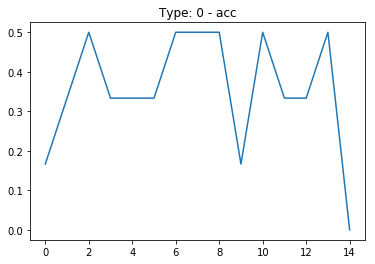

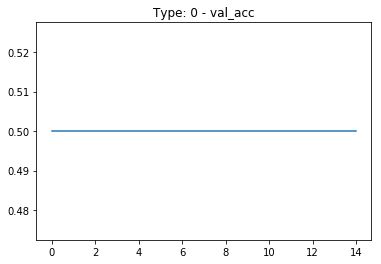

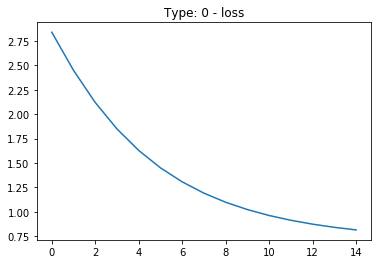

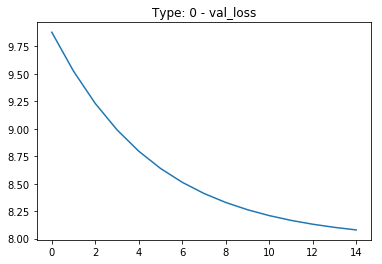

In [306]:
monitor_process(json_file, ["acc","val_acc","loss","val_loss"])

# Save model in json format

In [88]:
model_json = FaceModel.to_json()

In [89]:
with open("test_history/json_model.json", 'w') as json_file:
    json_file.write(model_json)